In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
print(keras.__version__)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from math import nan
from keras.callbacks import ModelCheckpoint

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

2.2.4
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-gad3gn6m
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-gad3gn6m
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=542f89589b3132e090d59d712121d74a4a47b38557dda723b3875e2d678ffe00
  Stored in directory: /tmp/pip-ephem-wheel-cache-26xgz49j/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
entity-annotated-corpus



In [2]:
import pkg_resources

packages = ['numpy', 'pandas', 'keras', 'keras-contrib', 'tensorflow']
# Add more packages as needed

for package in packages:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package.capitalize()} version: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package.capitalize()} is not installed.")


Numpy version: 1.17.0
Pandas version: 0.25.0
Keras version: 2.2.4
Keras-contrib version: 2.0.8
Tensorflow version: 1.14.0



## Importing the dataset for named entity recognition model

In [3]:
dframe = pd.read_csv("../input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [4]:
dframe

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
5,5,through,london,to,TO,lowercase,to,NNP,capitalized,London,...,have,VBP,lowercase,have,lowercase,marched,1.0,lowercase,through,O
6,6,london,to,protest,VB,lowercase,protest,TO,lowercase,to,...,march,VBN,lowercase,marched,lowercase,through,1.0,capitalized,London,B-geo
7,7,to,protest,the,DT,lowercase,the,VB,lowercase,protest,...,through,IN,lowercase,through,capitalized,London,1.0,lowercase,to,O
8,8,protest,the,war,NN,lowercase,war,DT,lowercase,the,...,london,NNP,capitalized,London,lowercase,to,1.0,lowercase,protest,O
9,9,the,war,in,IN,lowercase,in,NN,lowercase,war,...,to,TO,lowercase,to,lowercase,protest,1.0,lowercase,the,O


## Data preprocessing

In [5]:
!pip install ipython-autotime
%load_ext autotime

time: 645 µs (started: 2024-05-13 16:43:17 +00:00)


In [6]:
dframe.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

time: 3.71 ms (started: 2024-05-13 16:43:17 +00:00)


## We want word, pos, sentence_idx and tag as an input 

In [7]:
dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos"],axis=1)

time: 48.3 ms (started: 2024-05-13 16:43:17 +00:00)


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 4 columns):
sentence_idx    1050794 non-null float64
shape           1050794 non-null object
word            1050794 non-null object
tag             1050794 non-null object
dtypes: float64(1), object(3)
memory usage: 32.1+ MB
time: 323 ms (started: 2024-05-13 16:43:17 +00:00)


In [9]:
dataset = pd.read_csv("https://github.com/alwanrahmanas/ner/blob/main/labeled/combined%20data%20new%20format%20for%20bi-lstm.csv?raw=true")

#dataset = dataset.fillna(method="ffill")
dataset.head(100)

,Sentence #,Word,POS,Tag
0,Sentence: 1,memantau,NaN,O
1,Sentence: 1,pemanfaatan,NaN,O
2,Sentence: 1,wilayah,NaN,O
3,Sentence: 1,oleh,NaN,O
4,Sentence: 1,perusahaan.,NaN,O
5,Sentence: 1,Oleh,NaN,O
6,Sentence: 1,karena,NaN,O
7,Sentence: 1,itu,NaN,O
8,Sentence: 1,diperlukan,NaN,O
9,Sentence: 1,suatu,NaN,O


time: 1.1 s (started: 2024-05-13 16:43:18 +00:00)


In [10]:
dataset.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,memantau,NaN,O
1,Sentence: 1,pemanfaatan,NaN,O
2,Sentence: 1,wilayah,NaN,O
3,Sentence: 1,oleh,NaN,O
4,Sentence: 1,perusahaan.,NaN,O


time: 8.32 ms (started: 2024-05-13 16:43:19 +00:00)


In [11]:
# dataset=dataset.drop(['shape'],axis=1)

time: 370 µs (started: 2024-05-13 16:43:19 +00:00)


In [12]:
if 'POS' in dataset.columns:
    dataset.drop(['POS'], axis=1, inplace=True)

time: 4.45 ms (started: 2024-05-13 16:43:19 +00:00)


In [13]:
dataset['Word'] = dataset['Word'].str.lower()

time: 43.9 ms (started: 2024-05-13 16:43:19 +00:00)


## Create list of list of tuples to differentiate each sentence from each other

In [14]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                            s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)

        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped.get("Sentence: {}".format(self.n_sent), None)
            if s is not None:
                self.n_sent += 1
            return s
        except:
            return None

time: 2.93 ms (started: 2024-05-13 16:43:19 +00:00)


In [15]:
getter = SentenceGetter(dataset)

time: 181 ms (started: 2024-05-13 16:43:19 +00:00)


In [16]:
sentences = getter.sentences

time: 498 µs (started: 2024-05-13 16:43:19 +00:00)


In [17]:
print(sentences[5])

[(')', 'O'), ('dosen', 'O'), ('pembimbing', 'O'), (':', 'O'), ('dr.', 'O'), ('margaretha', 'O'), ('ari', 'O'), ('anggorowati', 'O'), (',', 'O'), ('s.kom.', 'O'), (',', 'O'), ('m.t', 'O'), ('ringkasan', 'O'), ('—', 'O'), ('bps', 'O'), ('telah', 'O'), ('melakukan', 'O'), ('berbagai', 'O'), ('riset', 'O'), ('dalam', 'O'), ('mengembangkan', 'O'), ('metode', 'O'), ('small', 'O'), ('area', 'O'), ('estimation', 'O'), ('(', 'O'), ('sae', 'O'), (')', 'O'), ('.', 'O'), ('hasil', 'O'), ('riset-riset', 'O'), ('yang', 'O'), ('telah', 'O'), ('dilakukan', 'O'), ('tersebut', 'O'), ('banyak', 'O'), ('yang', 'O'), ('telah', 'O'), ('diimplementasikan', 'O'), ('dalam', 'O'), ('bentuk', 'O'), ('r', 'O'), ('package', 'O'), ('dan', 'O'), ('saling', 'O'), ('terpisah', 'O'), ('antar', 'O'), ('riset', 'O'), ('satu', 'O'), ('dengan', 'O'), ('lainnya', 'O'), (',', 'O'), ('sehingga', 'O'), ('belum', 'O'), ('terintegrasi', 'O'), ('sebagai', 'O'), ('satu', 'O'), ('bagian', 'O'), ('yang', 'O'), ('utuh', 'O'), ('sebag

In [18]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 553
time: 1.21 ms (started: 2024-05-13 16:43:19 +00:00)


In [19]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

time: 3.63 ms (started: 2024-05-13 16:43:19 +00:00)


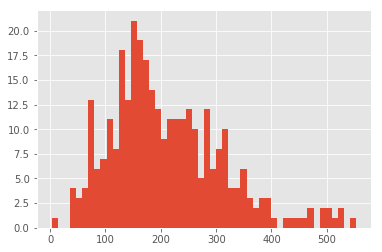

time: 414 ms (started: 2024-05-13 16:43:19 +00:00)


In [20]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [21]:
dataset["Word"]

0               memantau
1            pemanfaatan
2                wilayah
3                   oleh
4            perusahaan.
              ...       
66319         signifikan
66320             antara
66321         importance
66322                dan
66323    performance-nya
Name: Word, Length: 66324, dtype: object

time: 7.83 ms (started: 2024-05-13 16:43:19 +00:00)


In [22]:
words = list(set(dataset["Word"].values))
words.append("ENDPAD")

time: 8.65 ms (started: 2024-05-13 16:43:19 +00:00)


In [23]:
n_words = len(words); n_words

6766

time: 2.34 ms (started: 2024-05-13 16:43:19 +00:00)


## Fix the tags

In [24]:
dataset.head()

,Sentence #,Word,Tag
0,Sentence: 1,memantau,O
1,Sentence: 1,pemanfaatan,O
2,Sentence: 1,wilayah,O
3,Sentence: 1,oleh,O
4,Sentence: 1,perusahaan.,O


time: 16.8 ms (started: 2024-05-13 16:43:19 +00:00)


In [25]:
tags = []
for tag in set(dataset["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)

['I-METODE', 'B-TEMUAN', 'B-METODE', 'I-TUJUAN', 'B-TUJUAN', 'I-TEMUAN', 'O']
time: 3.73 ms (started: 2024-05-13 16:43:19 +00:00)


In [26]:
n_tags = len(tags); n_tags

7

time: 2.35 ms (started: 2024-05-13 16:43:20 +00:00)


**Converting words to numbers and numbers to words**

In [27]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

time: 7.78 ms (started: 2024-05-13 16:43:20 +00:00)


In [28]:
word2idx['nlp']

3127

time: 2.2 ms (started: 2024-05-13 16:43:20 +00:00)


In [29]:
tag2idx["B-TUJUAN"]

4

time: 2.02 ms (started: 2024-05-13 16:43:20 +00:00)


In [30]:
tag2idx

{'I-METODE': 0,
 'B-TEMUAN': 1,
 'B-METODE': 2,
 'I-TUJUAN': 3,
 'B-TUJUAN': 4,
 'I-TEMUAN': 5,
 'O': 6}

time: 2.39 ms (started: 2024-05-13 16:43:20 +00:00)


In [31]:
idx2tag[5]

'I-TEMUAN'

time: 2.16 ms (started: 2024-05-13 16:43:20 +00:00)


In [32]:
idx2tag

{0: 'I-METODE',
 1: 'B-TEMUAN',
 2: 'B-METODE',
 3: 'I-TUJUAN',
 4: 'B-TUJUAN',
 5: 'I-TEMUAN',
 6: 'O'}

time: 2.21 ms (started: 2024-05-13 16:43:20 +00:00)


In [33]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

time: 17.1 ms (started: 2024-05-13 16:43:20 +00:00)


In [34]:
np.array(X).shape

(316,)

time: 12 ms (started: 2024-05-13 16:43:20 +00:00)


In [35]:
dim=512

time: 504 µs (started: 2024-05-13 16:43:20 +00:00)


In [36]:
X = pad_sequences(maxlen=dim, sequences=X, padding="post",value=n_words - 1)

time: 24.1 ms (started: 2024-05-13 16:43:20 +00:00)


In [37]:
X

array([[1710, 3052, 5578, ..., 6765, 6765, 6765],
       [2169, 1065, 4543, ..., 6765, 6765, 6765],
       [4992, 1330, 3925, ..., 6765, 6765, 6765],
       ...,
       [1279, 5010, 4254, ..., 6765, 6765, 6765],
       [4074, 5793, 4874, ..., 6765, 6765, 6765],
       [3001, 2160, 3587, ..., 6765, 6765, 6765]], dtype=int32)

time: 3.71 ms (started: 2024-05-13 16:43:20 +00:00)


In [38]:
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[100])
print(y_idx[100])

[('penghitungan', 'O'), ('kemiripan', 'O'), ('fitur', 'O'), ('menggunakan', 'O'), ('cosine', 'O'), ('similarity', 'O'), ('dan', 'O'), ('linear', 'O'), ('regression.', 'O'), ('berdasarkan', 'O'), ('hasil', 'O'), ('evaluasi', 'O'), (',', 'O'), ('diperoleh', 'O'), ('bahwa', 'O'), ('model', 'B-TEMUAN'), ('fine-tuned', 'I-TEMUAN'), ('indobert', 'I-TEMUAN'), ('merupakan', 'I-TEMUAN'), ('model', 'I-TEMUAN'), ('terbaik', 'I-TEMUAN'), ('dengan', 'I-TEMUAN'), ('nilai', 'I-TEMUAN'), ('mae', 'I-TEMUAN'), ('dan', 'I-TEMUAN'), ('rmse', 'I-TEMUAN'), ('sebesar', 'I-TEMUAN'), ('0.1285', 'I-TEMUAN'), ('dan', 'I-TEMUAN'), ('0.2001.', 'I-TEMUAN'), ('model', 'O'), ('terbaik', 'O'), ('tersebut', 'O'), ('diimplementasikan', 'O'), ('dengan', 'O'), ('menggunakan', 'O'), ('framework', 'O'), ('flask', 'O'), ('pada', 'O'), ('python', 'O'), ('ke', 'O'), ('dalam', 'O'), ('website', 'O'), ('interaktif', 'O'), ('sederhana.', 'O')]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [39]:
y = pad_sequences(maxlen=dim, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y_idx[100])

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
time: 24.9 ms (started: 2024-05-13 16:43:20 +00:00)


In [40]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

time: 9.95 ms (started: 2024-05-13 16:43:20 +00:00)


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

time: 639 ms (started: 2024-05-13 16:43:20 +00:00)


## Import Keras

In [42]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k

time: 947 µs (started: 2024-05-13 16:43:20 +00:00)


## Keras version

In [43]:
print(k.__version__)

2.2.4
time: 1.13 ms (started: 2024-05-13 16:43:20 +00:00)


## Model
 **Pay attention to the word embedding size

input = Input(shape=(dim,))
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=dim)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.05, 
                           recurrent_dropout=0.05, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # previously softmax output layer

crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [44]:
import keras.backend as K

# Define custom loss functions
def focal_loss(y_true, y_pred, gamma=2.0):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return -K.sum((1 - y_pred) ** gamma * y_true * K.log(y_pred), axis=-1)

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return -(2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define custom metric function
def custom_metric(y_true, y_pred, method='focal'):
    # You can choose either Focal Loss or Dice Loss here
    if method == 'focal':
        loss = focal_loss(y_true, y_pred)
    elif method == 'dice':
        loss = dice_loss(y_true, y_pred)
    return loss



time: 3.31 ms (started: 2024-05-13 16:43:20 +00:00)


In [45]:
class CustomCRF(CRF):
    def call(self, inputs, mask=None, training=None):
        sequence_lengths = K.sum(K.cast(mask, 'int32'), axis=-1)
        self.sequence_lengths = sequence_lengths  # Store it for later use
        return super(CustomCRF, self).call(inputs, mask=mask, training=training)


time: 1.88 ms (started: 2024-05-13 16:43:20 +00:00)


In [46]:
n_tags

7

time: 1.97 ms (started: 2024-05-13 16:43:20 +00:00)


In [47]:
# Define your model
# Define your model
input = Input(shape=(dim,))
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=dim)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.05, 
                           recurrent_dropout=0.05, 
                           kernel_initializer='he_normal'))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer='he_normal')(model)
output = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # Softmax output layer




time: 2.6 s (started: 2024-05-13 16:43:20 +00:00)


In [48]:
# Define your model
model = Model(input, output)

time: 961 µs (started: 2024-05-13 16:43:23 +00:00)


In [49]:
adam = k.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
# #model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
# # Compile the model with custom loss
# model = Model(input, out)
# Compile the model with custom loss and accuracy metric
# Compile the model with custom loss and custom metric
model.compile(optimizer=adam, loss=custom_metric, metrics=[custom_metric])


time: 51.1 ms (started: 2024-05-13 16:43:23 +00:00)


In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 512, 300)          2029800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512, 600)          1442400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512, 600)          2882400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 512, 7)            4207      
Total params: 6,358,807
Trainable params: 6,358,807
Non-trainable params: 0
_________________________________________________________________
time: 3.57 ms (started: 2024-05-13 16:43:23 +00:00)


model

In [51]:
from tensorflow.keras.utils import plot_model

time: 2.36 ms (started: 2024-05-13 16:43:23 +00:00)


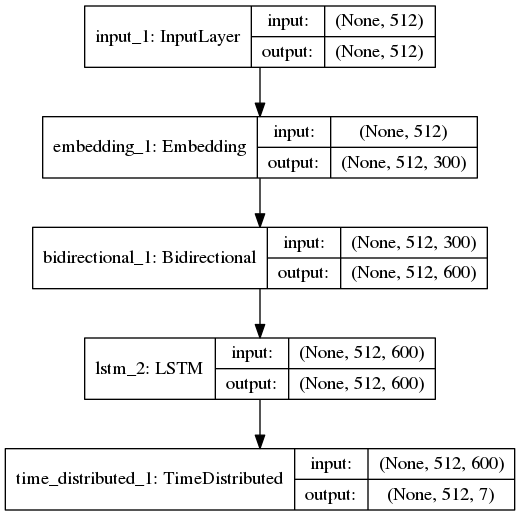

time: 1.5 s (started: 2024-05-13 16:43:23 +00:00)


In [52]:
# Assuming 'model' is your Keras model
plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

## Save the model after each epoch if validation is better

In [53]:
from keras.callbacks import Callback, ModelCheckpoint

# Define a custom callback to calculate validation accuracy
class ValidationAccuracy(Callback):
    def __init__(self, filepath):
        super(ValidationAccuracy, self).__init__()
        self.filepath = filepath
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_loss = logs.get('val_loss')
        if val_loss is None:
            return
        val_acc = 1 - val_loss  # Assuming higher val_loss means lower accuracy (change this if it's the opposite)
        logs['val_acc'] = val_acc

# Define the file path with the dynamic name
filepath = "ner-bi-lstm-td-model-{epoch:02d}-{val_acc:.2f}.hdf5"

# Create the custom callback instance
val_accuracy_callback = ValidationAccuracy(filepath)

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

# Use the callbacks in the training loop
callbacks_list = [val_accuracy_callback, checkpoint]


time: 3.38 ms (started: 2024-05-13 16:43:25 +00:00)


## Fit

from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
n_splits = 3  # for example, you can adjust this number as needed

# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store training/validation histories
training_histories = []
validation_histories = []

# Convert y_train to a NumPy array if it's not already one
y_train_array = np.array(y_train)

# Perform cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]

    # Fit the model on the current fold
    history = model.fit(X_train_fold, np.array(y_train_fold), batch_size=16, epochs=5, 
                        validation_data=(X_val_fold, np.array(y_val_fold)), verbose=1, 
                        callbacks=callbacks_list)
    
    # Store training/validation history
    training_histories.append(history.history['crf_viterbi_accuracy'])  # Use 'crf_viterbi_accuracy' instead of 'accuracy'
    validation_histories.append(history.history['val_crf_viterbi_accuracy'])  # Use 'val_crf_viterbi_accuracy' instead of 'val_accuracy'



In [54]:
# # Assuming X_train is your tokenized and padded input data
# print("Shape of X_train:", X_train.shape)

# # Assuming n_tags is the number of unique tags
# print("Number of unique tags (classes):", n_tags)

# # Confirm the last dimension of X_train matches the number of classes
# assert X_train.shape[-1] == n_tags, "Mismatch between the last dimension of X_train and the number of classes (n_tags)"


time: 3.6 ms (started: 2024-05-13 16:43:25 +00:00)


In [55]:
from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
n_splits = 7  # Adjust this number as needed
# Convert y_train to a NumPy array if it's not already one
y_train_array = np.array(y_train)
# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store training/validation histories
training_histories = []
validation_histories = []

# Perform cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]

    # Fit the model on the current fold
    history = model.fit(X_train_fold, np.array(y_train_fold), batch_size=64, epochs=100, 
                        validation_data=(X_val_fold, np.array(y_val_fold)), verbose=1, 
                        callbacks=callbacks_list)
    
    # Store training/validation history
    training_histories.append(history.history['custom_metric'])  # Use the name of your custom metric function
    validation_histories.append(history.history['val_custom_metric'])  # Use the name of your custom metric function


Train on 216 samples, validate on 36 samples
Epoch 1/100
216/216 [==============================] - 19s 87ms/step - loss: 1.2528 - custom_metric: 1.2528 - val_loss: 1.0101 - val_custom_metric: 1.0101

Epoch 00001: val_acc improved from -inf to -0.01007, saving model to ner-bi-lstm-td-model-01--0.01.hdf5
Epoch 2/100
216/216 [==============================] - 11s 53ms/step - loss: 0.8687 - custom_metric: 0.8687 - val_loss: 0.7264 - val_custom_metric: 0.7264

Epoch 00002: val_acc improved from -0.01007 to 0.27363, saving model to ner-bi-lstm-td-model-02-0.27.hdf5
Epoch 3/100
216/216 [==============================] - 11s 53ms/step - loss: 0.6097 - custom_metric: 0.6097 - val_loss: 0.6149 - val_custom_metric: 0.6149

Epoch 00003: val_acc improved from 0.27363 to 0.38506, saving model to ner-bi-lstm-td-model-03-0.39.hdf5
Epoch 4/100
216/216 [==============================] - 11s 53ms/step - loss: 0.5142 - custom_metric: 0.5142 - val_loss: 0.5601 - val_custom_metric: 0.5601

Epoch 00004: val

## Accumulate metrics by tag 

In [56]:
tag2idx

{'I-METODE': 0,
 'B-TEMUAN': 1,
 'B-METODE': 2,
 'I-TUJUAN': 3,
 'B-TUJUAN': 4,
 'I-TEMUAN': 5,
 'O': 6}

time: 3.45 ms (started: 2024-05-13 18:55:09 +00:00)


In [57]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1


time: 2.52 ms (started: 2024-05-13 18:55:09 +00:00)


In [58]:
TP

{'I-METODE': 0,
 'B-TEMUAN': 0,
 'B-METODE': 0,
 'I-TUJUAN': 0,
 'B-TUJUAN': 0,
 'I-TEMUAN': 0,
 'O': 0}

time: 2.36 ms (started: 2024-05-13 18:55:09 +00:00)


## Single prediction and verbose results

In [59]:
i = 3
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
print(gt)
print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
    #
    print("{:14}: ({:5}): {}".format(words[w],idx2tag[gt[idx]],tags[pred]))

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 3 3 3 3 3 3 3 3 3 3 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 0 0 6 6 6 6 6 6 2 0 0 0 0 0 0
 0 6 6 6 6 6 6 6 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 

## Predict everything at once

In [60]:
p = model.predict(np.array(X_train))  

time: 6.06 s (started: 2024-05-13 18:55:10 +00:00)


## The output is 3d: sent x word x tag prob (softmax)

In [61]:
p.shape

(252, 512, 7)

time: 2.22 ms (started: 2024-05-13 18:55:16 +00:00)


## Standard Classification Report

In [62]:
from sklearn.metrics import classification_report

time: 543 µs (started: 2024-05-13 18:55:16 +00:00)


Grab the 3d dimension and return the index of the highest probability ... the index matches the tag value
np.argmax(p, axis=2)

In [63]:
np.argmax(p, axis=2)[0]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

time: 7.75 ms (started: 2024-05-13 18:55:16 +00:00)


In [64]:
report=classification_report(np.argmax(y_train, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values()))
print(report)

              precision    recall  f1-score   support

    I-METODE       1.00      0.99      0.99      1509
    B-TEMUAN       0.96      0.94      0.95       468
    B-METODE       0.98      0.95      0.97       540
    I-TUJUAN       1.00      1.00      1.00      3652
    B-TUJUAN       1.00      0.98      0.99       238
    I-TEMUAN       1.00      1.00      1.00     11246
           O       1.00      1.00      1.00    111371

    accuracy                           1.00    129024
   macro avg       0.99      0.98      0.98    129024
weighted avg       1.00      1.00      1.00    129024

time: 140 ms (started: 2024-05-13 18:55:16 +00:00)


focal loss 256, 64, 50

              precision    recall  f1-score   support

    B-TUJUAN       0.73      0.68      0.70       197
    I-TUJUAN       0.97      0.99      0.98      3065
    I-TEMUAN       0.98      0.99      0.99     10834
    B-METODE       0.69      0.21      0.32       498
    I-METODE       0.87      0.85      0.86      1354
    B-TEMUAN       0.70      0.51      0.59       453
           O       0.99      0.99      0.99     48111

    accuracy                           0.98     64512
   macro avg       0.85      0.74      0.78     64512
weighted avg       0.98      0.98      0.98     64512

In [65]:
# import numpy as np

# prec = [0.69 , 0.0, 0.00, 0, 0.15, 0.08, 0.00]
# rec = [0.97, 0, 0.00, 0, 0.0, 0.02, 0]
# f1 = [0.8, 0.0, 0.00, 0, 0.01, 0.03, 0]

# av_prec = np.mean(prec)
# av_rec = np.mean(rec)
# av_f1 = np.mean(f1)


time: 410 µs (started: 2024-05-13 18:55:17 +00:00)


In [66]:
# print("Average Precision:", av_prec)
# print("Average Recall:", av_rec)
# print("Average F1-score:", av_f1)


time: 387 µs (started: 2024-05-13 18:55:17 +00:00)


## Accumulate the scores by tag

In [67]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(p[i], axis=-1)
    gt = np.argmax(y_test[i], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

time: 74 ms (started: 2024-05-13 18:55:17 +00:00)


## How did Classification perform for each tag

In [68]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))    

tag:I-METODE
	 TN:       124	FP:         0
	 FN:       201	TP:         6
tag:B-TEMUAN
	 TN:        23	FP:         0
	 FN:        97	TP:         1
tag:B-METODE
	 TN:        46	FP:         0
	 FN:        99	TP:         0
tag:I-TUJUAN
	 TN:        87	FP:         0
	 FN:       793	TP:       133
tag:B-TUJUAN
	 TN:         9	FP:         0
	 FN:        49	TP:         2
tag:I-TEMUAN
	 TN:       279	FP:         0
	 FN:      2159	TP:       416
tag:O
	 TN:         0	FP:      3908
	 FN:         0	TP:     24336
time: 1.92 ms (started: 2024-05-13 18:55:17 +00:00)


In [69]:
# Summing all values in the dictionaries
total_TP = sum(TP.values())
total_TN = sum(TN.values())
total_FP = sum(FP.values())
total_FN = sum(FN.values())

# Printing the totals
print("Total TP:", total_TP)
print("Total TN:", total_TN)
print("Total FP:", total_FP)
print("Total FN:", total_FN)


Total TP: 24894
Total TN: 568
Total FP: 3908
Total FN: 3398
time: 2.11 ms (started: 2024-05-13 18:55:17 +00:00)


In [70]:
# ALL METRIC 
import math

prec= total_TP/(total_TP+total_FP)
rec = total_TP/(total_TP+total_FN)
f1=2*prec*rec/(prec+rec)

# Print the metrics
print("Precision:", round(prec,3))
print("Recall:", round(rec,3))
print("F1-score:", round(f1,3))

Precision: 0.864
Recall: 0.88
F1-score: 0.872
time: 1.62 ms (started: 2024-05-13 18:55:17 +00:00)


tanpa layer lstm tambahan:

Precision: 0.9708141321044547
Recall: 0.9210784779647055
F1-score: 0.9452925588125315